In [140]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

In [141]:
#Calibrating the Camera

#filenames of all calibration images
files = glob.glob('./camera_cal/calibration*.jpg')

chessshape = (9,6)
objpoints = [] # Real world coordinates in 3D
imgpoints = [] # 2D points in image plane

cal_images = [] # all images of calibration

# setup object points consant for each calibration image
objp = np.zeros((chessshape[0]*chessshape[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:chessshape[0],0:chessshape[1]].T.reshape(-1,2)

# iterate through all images
for fname in files:
    # read image
    image = cv2.imread(fname)
    cal_images.append(np.copy(image))
    # convert to grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # find chesscorners
    ret, corners = cv2.findChessboardCorners(gray, chessshape, None)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        img = cv2.drawChessboardCorners(image, chessshape, corners, ret)

# Actual calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

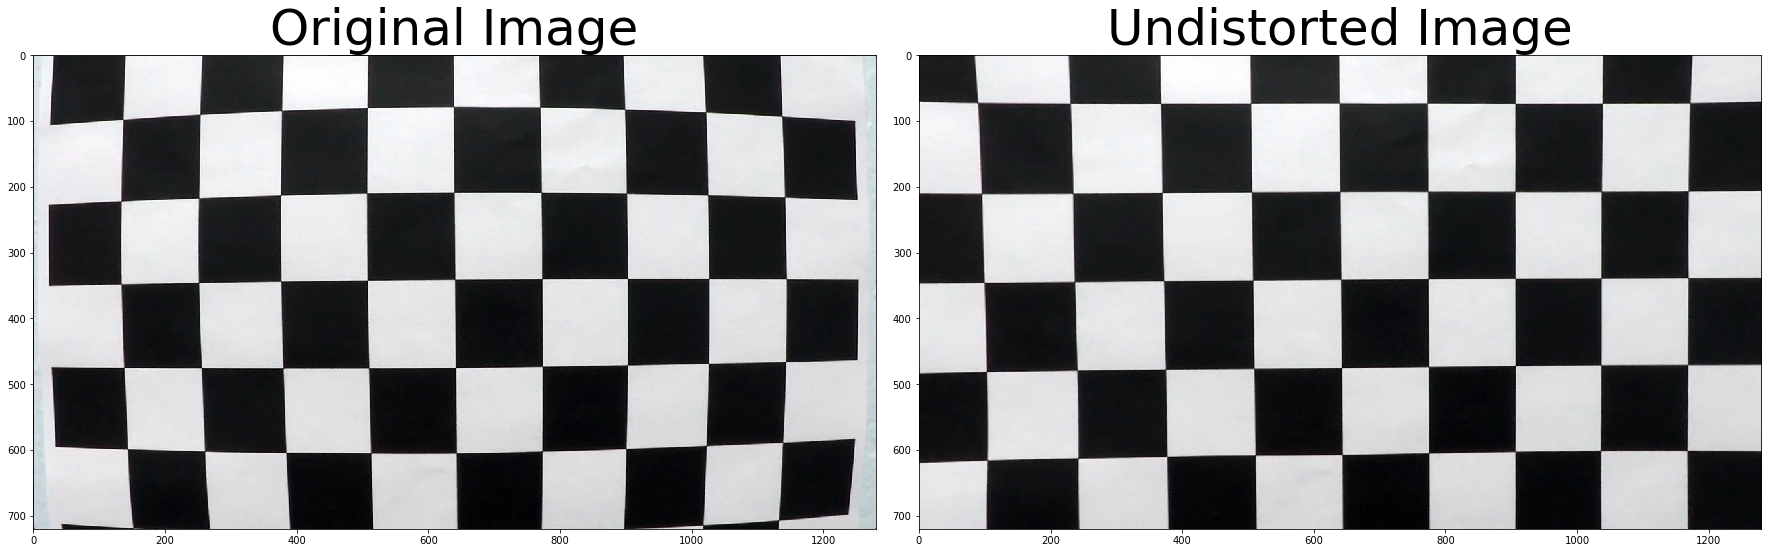

In [142]:
# test calibration on chessboard

# test calibration image
test_cal_image = cv2.imread('./camera_cal/calibration1.jpg')

dst = cv2.undistort(test_cal_image, mtx, dist, None, mtx)

# Plot calibration result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_cal_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


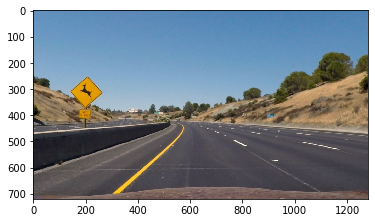

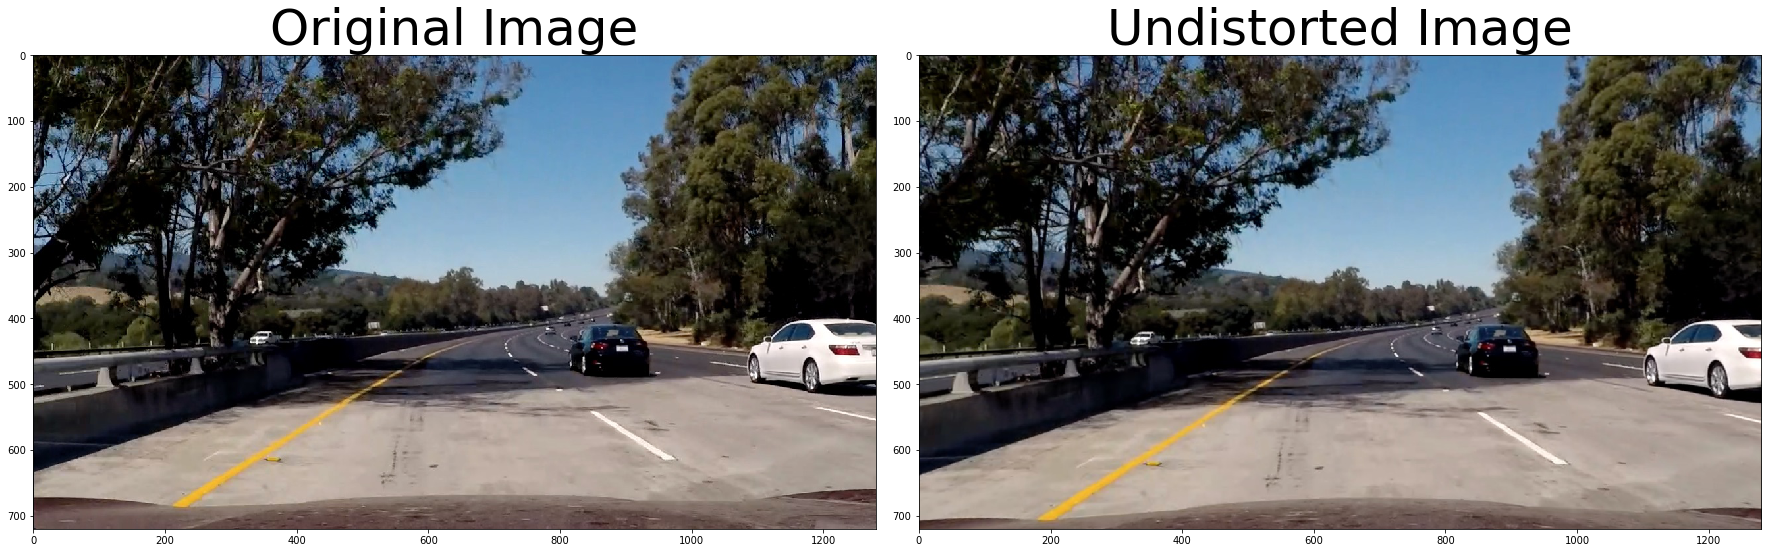

In [149]:
 # test calibration on image of road


# test images
test_files = glob.glob('./test_images/*.jpg')
test_files.sort()
test_images = []
for test_file in test_files:
    test_image = cv2.imread(test_file)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    test_image = cv2.undistort(test_image, mtx, dist, None, mtx)
    test_images.append(test_image)

# test image
test_image = cv2.imread('./test_images/test5.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
dst = cv2.undistort(test_image, mtx, dist, None, mtx)


# Plot calibration result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


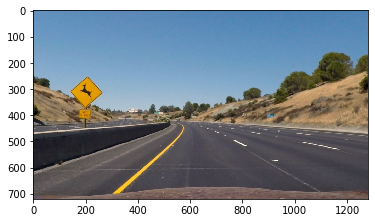

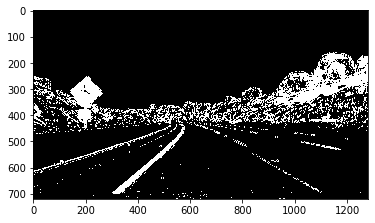

In [185]:
# show image
def show(img):
    plt.figure()
    plt.imshow(img, cmap='gray')

# Converts image to gray image
def cvtGray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Applies thresholds to image
def threshold(img, thresh=(0, 255)):
    binary_output = np.zeros_like(img)
    binary_output[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return binary_output

# Scales the image to use full spectrum from 255
def scale(img): 
    return np.uint8(255*img/np.max(img))

# combines to images with 'and' or 'or' operator
def combine(img, operator, img2):
    binary_output = np.zeros_like(img)
    if(operator == 'and'):
        binary_output[(img == 1) & (img2 == 1)] = 1
    elif(operator == 'or'):
        binary_output[(img == 1) | (img2 == 1)] = 1
    return binary_output

def potLanePixel(img):
    gray = cvtGray(img)
    # gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 9)
    # absolute value of the x
    abs_sobelx = np.abs(sobelx)

    scaled_sobelx = scale(abs_sobelx)

    bin_sobelx = threshold(scaled_sobelx, thresh=(20,100))

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    sat = threshold(S, thresh=(90,255))
    hue = threshold(H, thresh=(15,100))

    combo_s_h = combine(sat,'and', hue) 
 
    result = combine(combo_s_h,'or', bin_sobelx)
    return result



 # show image
show(test_images[3])
show(potLanePixel(test_images[3]))

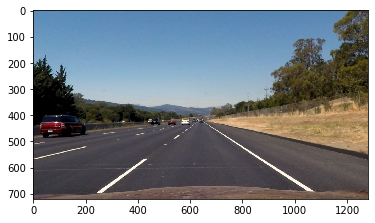

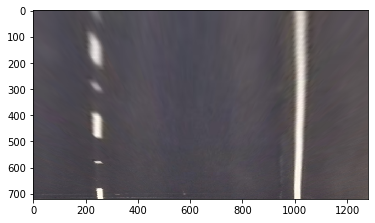

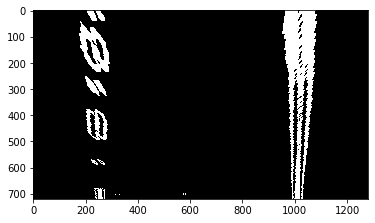

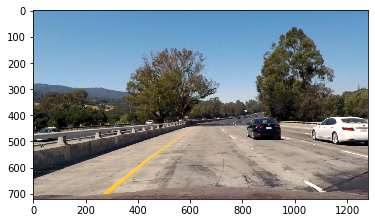

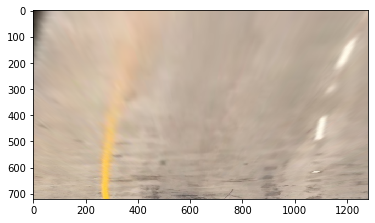

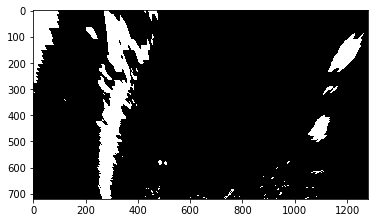

In [188]:
# transform perspective to birdseye

perspective_test = test_images[2]


# approximated from an image with straight lane lines
src = np.float32([[250,690],[1050,690],[597,450],[686,450]])
dst = np.float32([[250,760],[1000,760],[250,0],[1000,0]])

M = cv2.getPerspectiveTransform(src, dst)

def warp(img):
    return cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)

show(test_images[1])
show(warp(test_images[1]))
show(warp(potLanePixel(test_images[1])))

show(perspective_test)
show(warp(perspective_test))
show(warp(potLanePixel(perspective_test)))

In [237]:
# identify lines out of potential lane line pixels

def base_points(img):
    bottom_half = img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    midpoint = img.shape[1]//2
    return np.argmax(histogram[:midpoint]), np.argmax(histogram[midpoint:]) + midpoint

image = test_images[0]

warp_bin = warp(potLanePixel(image))

def fin_start_lane_pixels(warp_bin):
    leftx_base, rightx_base = base_points(warp_bin)

    out_img = np.dstack((warp_bin, warp_bin, warp_bin))

    n_win = 9

    margin = 100

    minpix = 50

    window_height = np.int(image.shape[0]//n_win)

    nonzero = warp_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = left_base
    rightx_current = right_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(n_win):
        win_y_low = warp_bin.shape[0] - (window+1) * window_height
        win_y_high = warp_bin.shape[0] - window * window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(left_inds)
        right_lane_inds.append(right_inds)

        if len(left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[left_inds]))

        if len(right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[right_inds]))

    return leftx, lefty, rightx, righty, out_img

    

In [238]:
# fit polynomial
def fitPolynomial(warp_bin):
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]


    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    ploty = np.linspace(0, warp_bin.shape[0]-1, warp_bin.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img = np.dstack((warp_bin, warp_bin, warp_bin))

    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    return out_img


ValueError: zero-dimensional arrays cannot be concatenated